# Diabetic Retinopathy Classifications


## Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0  
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import cv2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2 , EfficientNetB0 , ResNet50 , DenseNet121 , EfficientNetV2B0


In [ ]:
import warnings
warnings.simplefilter("ignore")

# Understanding the dataset and the problem 
## What is Diabetic Retinopathy?🩺
Diabetic Retinopathy (DR) is a complication of diabetes that affects the eyes. It occurs when high blood sugar levels damage the blood vessels in the retina, leading to vision problems and potentially permanent blindness if untreated. DR progresses through various stages, ranging from mild abnormalities to severe retinal damage.

Early detection of DR is critical to prevent vision loss. Retinal fundus imaging, where photographs of the back of the eye are captured, is a common diagnostic tool. AI-driven models can assist ophthalmologists by analyzing these images for signs of diabetic retinopathy.

## Dataset Overview
The dataset used for this project contains resized retinal images, categorized into different severity levels of diabetic retinopathy. The images are preprocessed and standardized for easier analysis and modeling.

**Classes in the Dataset**
The dataset is organized into five classes, each representing a specific stage of diabetic retinopathy:

1. Class 0: No DR

    Description: The retina shows no signs of diabetic retinopathy.
    Clinical Significance: Indicates healthy eyes with no damage.

2. Class 1: Mild DR

    Description: Small areas of swelling in the retina's blood vessels, known as microaneurysms, are     present.
    Clinical Significance: Early stage of DR; minimal impact on vision.

3. Class 2: Moderate DR

    Description: Blood vessels in the retina begin to swell and distort. Small hemorrhages and exudates may appear.
    Clinical Significance: Requires close monitoring and medical intervention.

4. Class 3: Severe DR

    Description: A significant number of blood vessels are blocked, leading to areas of ischemia (lack of oxygen). Hemorrhages and exudates are more pronounced.
   Clinical Significance: High risk of vision loss without immediate treatment.

5. Class 4: Proliferative DR

    Description: Advanced stage of DR where abnormal blood vessels grow on the retina. These vessels may rupture, leading to bleeding in the eye.
    Clinical Significance: Severe vision impairment or blindness if untreated.


In [19]:
# Defining paths for different classes
Main_Non_DR = Path("D:/Diabetic Retinopathy Project/VisionCare-AI--Diabetic-Retinopathy-Classifier/Dataset/0")
Main_Mild_DR = Path("D:/Diabetic Retinopathy Project/VisionCare-AI--Diabetic-Retinopathy-Classifier/Dataset/1")
Main_Moderate_DR = Path("D:/Diabetic Retinopathy Project/VisionCare-AI--Diabetic-Retinopathy-Classifier/Dataset/2")
Main_Severe_DR = Path("D:/Diabetic Retinopathy Project/VisionCare-AI--Diabetic-Retinopathy-Classifier\Dataset/3")
Main_Proliferative_DR = Path("D:/Diabetic Retinopathy Project/VisionCare-AI--Diabetic-Retinopathy-Classifier/Dataset/4")

In [20]:
# Taking only jpeg files 
Non_DR_Path = list(Main_Non_DR.glob(r"*.jpeg"))
Mild_DR_Path = list(Main_Mild_DR.glob(r"*.jpeg"))
Moderate_DR_Path = list(Main_Moderate_DR.glob(r"*.jpeg"))
Severe_DR_Path = list(Main_Severe_DR.glob(r"*.jpeg"))
Proliferative_DR_Path = list(Main_Proliferative_DR.glob(r"*.jpeg"))

In [21]:
# Type conversion
NON_DR_Path_Series = pd.Series(Non_DR_Path,name="JPEG").astype(str)
Mild_DR_Series = pd.Series(Mild_DR_Path, name="JPEG").astype(str)
Moderate_DR_Series = pd.Series(Moderate_DR_Path, name="JPEG").astype(str)
Severe_DR_Series = pd.Series(Severe_DR_Path, name="JPEG").astype(str)
Proliferative_DR_Series = pd.Series(Proliferative_DR_Path, name="JPEG").astype(str)

print(NON_DR_Path_Series.head(-1))
print(Mild_DR_Series.head(-1))
print(Moderate_DR_Series.head(-1))
print(Severe_DR_Series.head(-1))
print(Proliferative_DR_Series.head(-1))

0        D:\Diabetic Retinopathy Project\VisionCare-AI-...
1        D:\Diabetic Retinopathy Project\VisionCare-AI-...
2        D:\Diabetic Retinopathy Project\VisionCare-AI-...
3        D:\Diabetic Retinopathy Project\VisionCare-AI-...
4        D:\Diabetic Retinopathy Project\VisionCare-AI-...
                               ...                        
25804    D:\Diabetic Retinopathy Project\VisionCare-AI-...
25805    D:\Diabetic Retinopathy Project\VisionCare-AI-...
25806    D:\Diabetic Retinopathy Project\VisionCare-AI-...
25807    D:\Diabetic Retinopathy Project\VisionCare-AI-...
25808    D:\Diabetic Retinopathy Project\VisionCare-AI-...
Name: JPEG, Length: 25809, dtype: object
0       D:\Diabetic Retinopathy Project\VisionCare-AI-...
1       D:\Diabetic Retinopathy Project\VisionCare-AI-...
2       D:\Diabetic Retinopathy Project\VisionCare-AI-...
3       D:\Diabetic Retinopathy Project\VisionCare-AI-...
4       D:\Diabetic Retinopathy Project\VisionCare-AI-...
                    

## Visualization

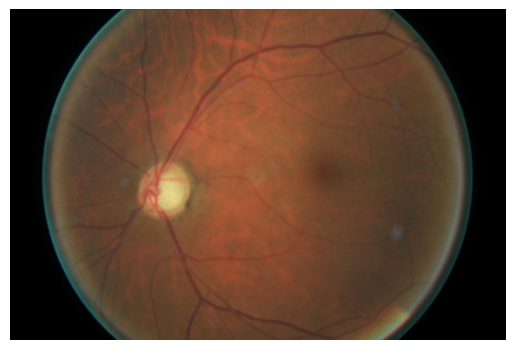

In [22]:

img_path = NON_DR_Path_Series[290]  
img = cv2.imread(img_path)  

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.axis('off')  
plt.show()

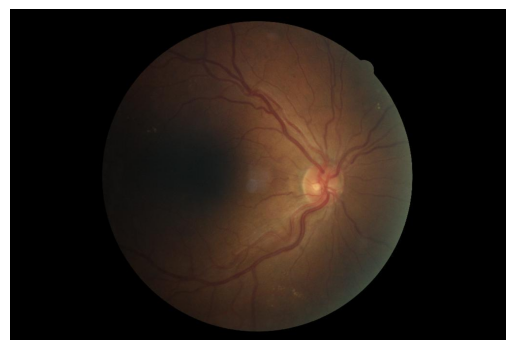

In [23]:
img_path = Moderate_DR_Series[290]  
img = cv2.imread(img_path)  

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.axis('off')  
plt.show()

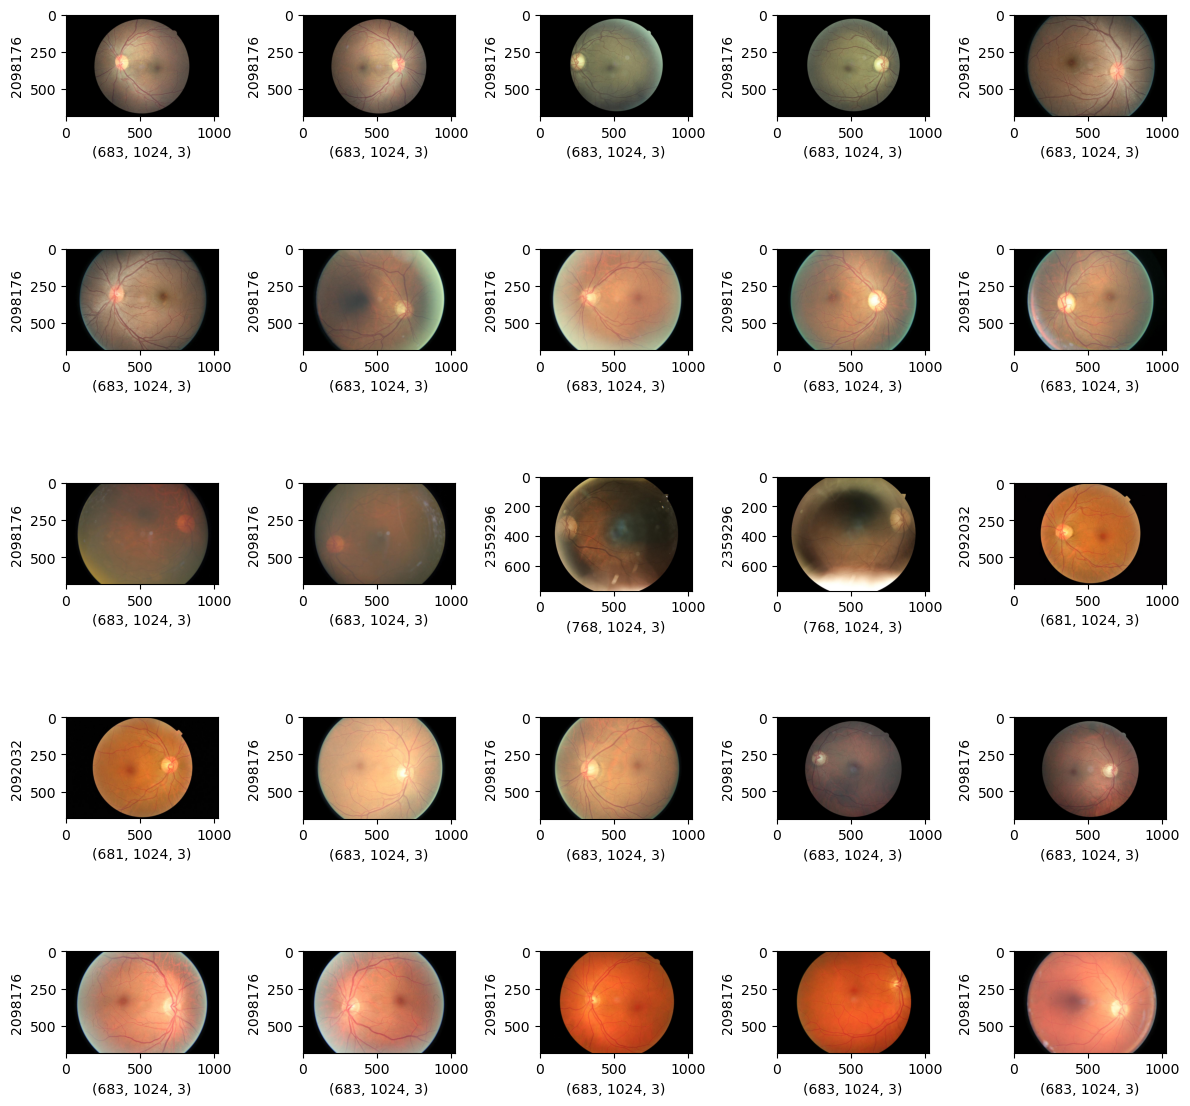

In [24]:
figure,axis = plt.subplots(nrows=5,ncols=5,figsize=(12,12))

for i,ax in enumerate(axis.flat):
    IMG_X = cv2.imread(NON_DR_Path_Series[i])
    IMG_X = cv2.cvtColor(IMG_X,cv2.COLOR_BGR2RGB)
    ax.set_xlabel(IMG_X.shape)
    ax.set_ylabel(IMG_X.size)
    ax.imshow(IMG_X)
plt.tight_layout()
plt.show()

## Train-Test Split

In [25]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

# Combine all image paths and labels
all_paths = (
    NON_DR_Path_Series.tolist() +
    Mild_DR_Series.tolist() +
    Moderate_DR_Series.tolist() +
    Severe_DR_Series.tolist() +
    Proliferative_DR_Series.tolist()
)
all_labels = (
    [0] * len(NON_DR_Path_Series) +
    [1] * len(Mild_DR_Series) +
    [2] * len(Moderate_DR_Series) +
    [3] * len(Severe_DR_Series) +
    [4] * len(Proliferative_DR_Series)
)

# Create a DataFrame for paths and labels
data = pd.DataFrame({"path": all_paths, "label": all_labels})

# Compute class weights based on label distribution
class_weights = compute_class_weight(
    class_weight="balanced", 
    classes=np.unique(data["label"]), 
    y=data["label"]
)
class_weights = {i: weight for i, weight in enumerate(class_weights)}

# Print the class weights for reference
print("Class Weights:", class_weights)

# Perform stratified train-test split
train_df, test_df = train_test_split(
    data, 
    test_size=0.2, 
    stratify=data["label"], 
    random_state=42
)

print("Train Data Distribution:\n", train_df["label"].value_counts())
print("Test Data Distribution:\n", test_df["label"].value_counts())

Class Weights: {0: 0.27218907400232467, 1: 2.875644699140401, 2: 1.3275132275132275, 3: 8.047193585337915, 4: 9.922598870056497}
Train Data Distribution:
 label
0    20648
2     4234
1     1954
3      698
4      566
Name: count, dtype: int64
Test Data Distribution:
 label
0    5162
2    1058
1     489
3     175
4     142
Name: count, dtype: int64


In [26]:
train_df['label'] = train_df['label'].apply(str)
test_df['label'] = test_df['label'].apply(str)

# Image dimensions
IMG_SIZE = (224, 224)  # MobileNet standard input size

# Data Augmentation and Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=20,  # Randomly rotate images
    horizontal_flip=True,  # Flip images horizontally
    fill_mode="nearest"  # Fill empty pixels
)

test_datagen = ImageDataGenerator(
    rescale=1./255  # Only normalize
)

# Prepare train and test generators
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col="path",
    y_col="label",  # String labels are required for categorical mode
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=32
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col="path",
    y_col="label",
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=32,
    shuffle=False
)

Found 28100 validated image filenames belonging to 5 classes.
Found 7026 validated image filenames belonging to 5 classes.


## MobileNetV2

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image size and classes
IMG_SIZE = (224, 224)
num_classes = len(train_generator.class_indices)  # Automatically get number of classes





# Load pre-trained MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# Unfreeze some layers for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-20]:  # Keep the first N layers frozen
    layer.trainable = False

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),  # Add dropout for regularization
    Dense(256, activation='relu'),  # Fully connected layer
    Dropout(0.3),  # Add another dropout layer
    Dense(num_classes, activation='softmax')  # Output layer
])

# Compile the model with a reduced learning rate
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks for learning rate reduction and early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Summary of the model
model.summary()

# Train the model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=20,  # Increased number of epochs
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=test_generator.samples // test_generator.batch_size,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")

# Save the model
model.save("diabetic_retinopathy_mobilenetv2_finetuned.h5")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,587,205 (9.87 MB)

 Trainable params: 1,535,301 (5.86 MB)

 Non-trainable params: 1,051,904 (4.01 MB)

Epoch 1/20
490/878 ━━━━━━━━━━━━━━━━━━━━ 9:44 2s/step - accuracy: 0.6857 - loss: 0.9768

In [12]:

# Define image size and classes
IMG_SIZE = (224, 224)
num_classes = len(train_generator.class_indices)  # Automatically get number of classes

# Load pre-trained MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# Freeze the base model layers
base_model.trainable = False

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),  # Fully connected layer
    Dense(num_classes, activation='softmax')  # Output layer
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model.summary()

# Train the model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=test_generator.samples // test_generator.batch_size
)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")

# Save the model
model.save("diabetic_retinopathy_mobilenetv2.h5")


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,587,205 (9.87 MB)

 Trainable params: 329,221 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

d:\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 5374s 6s/step - accuracy: 0.7308 - loss: 0.8532 - val_accuracy: 0.7389 - val_loss: 0.7809
Epoch 2/10
  1/878 ━━━━━━━━━━━━━━━━━━━━ 6:51 469ms/step - accuracy: 0.6562 - loss: 0.9842

d:\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


878/878 ━━━━━━━━━━━━━━━━━━━━ 1s 510us/step - accuracy: 0.6562 - loss: 0.9842 - val_accuracy: 0.7222 - val_loss: 0.8191
Epoch 3/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 1199s 1s/step - accuracy: 0.7403 - loss: 0.7847 - val_accuracy: 0.7409 - val_loss: 0.7829
Epoch 4/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 1s 408us/step - accuracy: 0.6562 - loss: 0.8232 - val_accuracy: 0.7222 - val_loss: 0.8097
Epoch 5/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 1386s 2s/step - accuracy: 0.7449 - loss: 0.7680 - val_accuracy: 0.7384 - val_loss: 0.8026
Epoch 6/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 1s 431us/step - accuracy: 0.6562 - loss: 0.9320 - val_accuracy: 0.7222 - val_loss: 0.8058
Epoch 7/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 8001s 9s/step - accuracy: 0.7430 - loss: 0.7681 - val_accuracy: 0.7434 - val_loss: 0.7730
Epoch 8/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 1s 401us/step - accuracy: 0.6875 - loss: 1.0818 - val_accuracy: 0.7778 - val_loss: 0.8037
Epoch 9/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 1000s 1s/step - accuracy: 0.7492 - loss: 0.7463 - val_accurac

Test Accuracy: 0.75


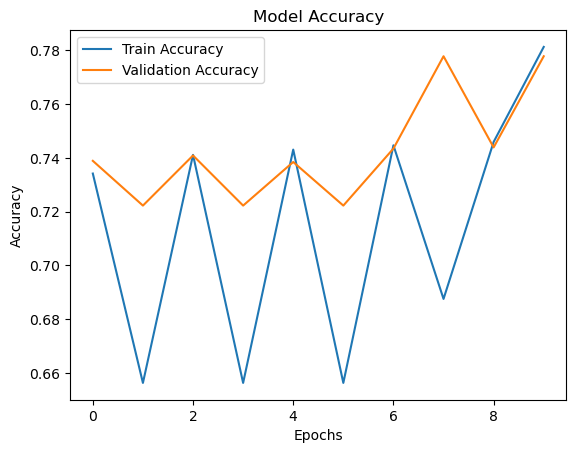

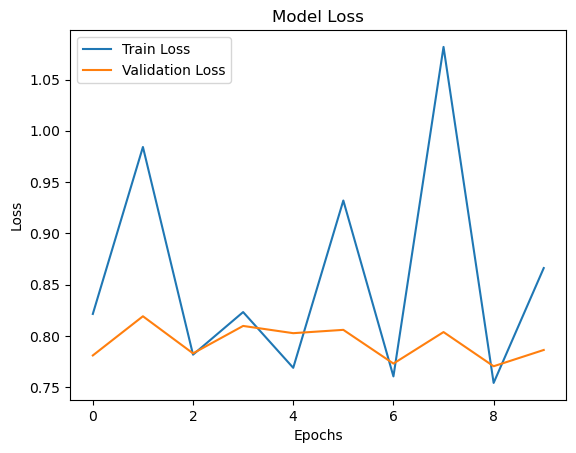

In [14]:


# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## EffiecientNetB0

In [16]:

# Define image size and number of classes
IMG_SIZE = (224, 224)
num_classes = len(train_generator.class_indices)  

# Load pre-trained EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# Freeze the base model layers
base_model.trainable = False

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),  # Fully connected layer
    Dense(num_classes, activation='softmax')  # Output layer
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=test_generator.samples // test_generator.batch_size
)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")

# Save the model
model.save("diabetic_retinopathy_efficientnetb0.h5")


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,378,792 (16.70 MB)

 Trainable params: 329,221 (1.26 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 1040s 1s/step - accuracy: 0.7281 - loss: 0.9007 - val_accuracy: 0.7347 - val_loss: 0.8768
Epoch 2/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 1s 639us/step - accuracy: 0.6562 - loss: 0.9679 - val_accuracy: 0.7222 - val_loss: 0.8239
Epoch 3/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 991s 1s/step - accuracy: 0.7267 - loss: 0.8950 - val_accuracy: 0.7347 - val_loss: 0.8690
Epoch 4/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 1s 384us/step - accuracy: 0.8438 - loss: 0.6769 - val_accuracy: 0.7222 - val_loss: 0.8311
Epoch 5/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 870s 990ms/step - accuracy: 0.7377 - loss: 0.8671 - val_accuracy: 0.7347 - val_loss: 0.9012
Epoch 6/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 1s 628us/step - accuracy: 0.8438 - loss: 0.5066 - val_accuracy: 0.7222 - val_loss: 0.8625
Epoch 7/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 1045s 1s/step - accuracy: 0.7314 - loss: 0.8804 - val_accuracy: 0.7347 - val_loss: 0.8784
Epoch 8/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 1s 376us/step - accuracy: 0.9062 - loss: 0.5560 -

Test Accuracy: 0.73


### Fine - Tuning the model 

In [17]:
# Unfreeze the base model for fine-tuning
base_model.trainable = True

# Recompile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model
history_fine_tune = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=5,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=test_generator.samples // test_generator.batch_size
)


Epoch 1/5
878/878 ━━━━━━━━━━━━━━━━━━━━ 3062s 3s/step - accuracy: 0.4274 - loss: 1.7265 - val_accuracy: 0.7347 - val_loss: 0.8643
Epoch 2/5
878/878 ━━━━━━━━━━━━━━━━━━━━ 4s 956us/step - accuracy: 0.5938 - loss: 1.3715 - val_accuracy: 0.7222 - val_loss: 0.8952
Epoch 3/5
878/878 ━━━━━━━━━━━━━━━━━━━━ 2912s 3s/step - accuracy: 0.7374 - loss: 0.8275 - val_accuracy: 0.7344 - val_loss: 0.9610
Epoch 4/5
878/878 ━━━━━━━━━━━━━━━━━━━━ 3s 454us/step - accuracy: 0.8438 - loss: 0.5707 - val_accuracy: 0.7222 - val_loss: 0.9118
Epoch 5/5
878/878 ━━━━━━━━━━━━━━━━━━━━ 3213s 4s/step - accuracy: 0.7370 - loss: 0.7941 - val_accuracy: 0.7349 - val_loss: 0.8645


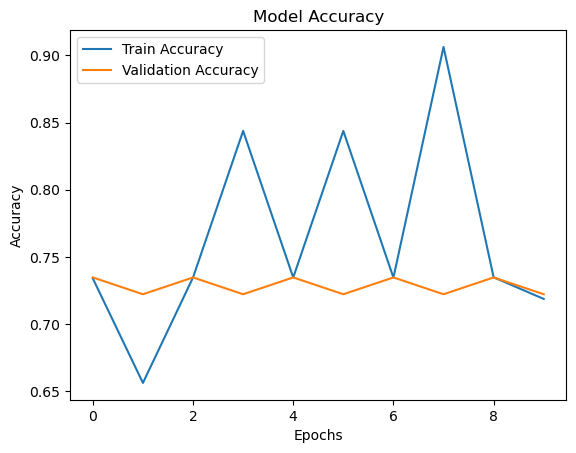

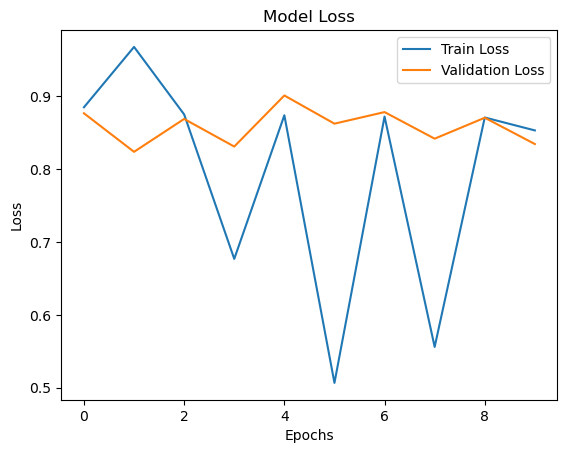

In [18]:

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


### ResNet50

In [20]:
# Define image size and number of classes
IMG_SIZE = (224, 224)
num_classes = len(train_generator.class_indices)  # Automatically determine the number of classes

# Load pre-trained ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# Freeze the base model layers
base_model.trainable = False

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),  # Fully connected layer
    Dense(num_classes, activation='softmax')  # Output layer for multi-class classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=test_generator.samples // test_generator.batch_size
)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")

# Save the model
model.save("diabetic_retinopathy_resnet50.h5")


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 67s 1us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,113,541 (91.99 MB)

 Trainable params: 525,829 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 2509s 3s/step - accuracy: 0.7280 - loss: 0.9260 - val_accuracy: 0.7347 - val_loss: 0.8852
Epoch 2/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7500 - loss: 0.8713 - val_accuracy: 0.7222 - val_loss: 0.8777
Epoch 3/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 6497s 7s/step - accuracy: 0.7328 - loss: 0.8792 - val_accuracy: 0.7347 - val_loss: 0.8694
Epoch 4/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8125 - loss: 0.6979 - val_accuracy: 0.7222 - val_loss: 0.8594
Epoch 5/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 2463s 3s/step - accuracy: 0.7358 - loss: 0.8728 - val_accuracy: 0.7347 - val_loss: 0.8698
Epoch 6/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7812 - loss: 0.7730 - val_accuracy: 0.7222 - val_loss: 0.8457
Epoch 7/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 2173s 2s/step - accuracy: 0.7374 - loss: 0.8690 - val_accuracy: 0.7347 - val_loss: 0.8714
Epoch 8/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6875 - loss: 0.9636 - val_accu

Test Accuracy: 0.73


### DenseNet121

In [22]:

# Define image size and number of classes
IMG_SIZE = (224, 224)
num_classes = len(train_generator.class_indices)

# Load DenseNet121 pre-trained on ImageNet
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# Freeze the base model
base_model.trainable = False

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=test_generator.samples // test_generator.batch_size
)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")

# Save the model
model.save("diabetic_retinopathy_densenet121.h5")


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step
Epoch 1/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 2613s 3s/step - accuracy: 0.7276 - loss: 0.8809 - val_accuracy: 0.7349 - val_loss: 0.8171
Epoch 2/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8125 - loss: 0.7030 - val_accuracy: 0.7778 - val_loss: 0.8772
Epoch 3/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 1742s 2s/step - accuracy: 0.7358 - loss: 0.7968 - val_accuracy: 0.7439 - val_loss: 0.7598
Epoch 4/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6562 - loss: 0.8379 - val_accuracy: 0.7778 - val_loss: 0.7715
Epoch 5/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 1832s 2s/step - accuracy: 0.7416 - loss: 0.7708 - val_accuracy: 0.7393 - val_loss: 0.7844
Epoch 6/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7500 - loss: 0.7151 - val_accuracy: 0.7222 - val_loss: 0.8483
Epoch 7/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 1937s 2s/step - accuracy: 0.7400 - loss: 0.7760 - val_accuracy: 0.7449 - val_loss: 0.7576
Epoch 8/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 3s 1

Test Accuracy: 0.74


### Vision Transformer

In [24]:

# Define image size and number of classes
IMG_SIZE = (224, 224)
num_classes = len(train_generator.class_indices)

# Load EfficientNetV2B0 pre-trained on ImageNet
base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# Freeze the base model
base_model.trainable = False

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=test_generator.samples // test_generator.batch_size
)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")

# Save the model
model.save("diabetic_retinopathy_vit.h5")


24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step
Epoch 1/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 726s 809ms/step - accuracy: 0.7289 - loss: 0.8958 - val_accuracy: 0.7347 - val_loss: 0.8711
Epoch 2/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 1s 604us/step - accuracy: 0.6562 - loss: 1.0037 - val_accuracy: 0.7222 - val_loss: 0.8286
Epoch 3/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 773s 880ms/step - accuracy: 0.7399 - loss: 0.8647 - val_accuracy: 0.7347 - val_loss: 0.8706
Epoch 4/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 1s 343us/step - accuracy: 0.7500 - loss: 0.7502 - val_accuracy: 0.7222 - val_loss: 0.8506
Epoch 5/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 784s 894ms/step - accuracy: 0.7320 - loss: 0.8771 - val_accuracy: 0.7347 - val_loss: 0.8747
Epoch 6/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 1s 450us/step - accuracy: 0.5938 - loss: 1.1367 - val_accuracy: 0.7222 - val_loss: 0.8567
Epoch 7/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 788s 897ms/step - accuracy: 0.7387 - loss: 0.8650 - val_accuracy: 0.7347 - val_loss: 0.8699
Epoch 8/10
878/878 ━━━━━━━━━━━━

Test Accuracy: 0.73


### Xception

In [25]:
from tensorflow.keras.applications import Xception

# Load pre-trained Xception model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# Freeze the base model
base_model.trainable = False

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=test_generator.samples // test_generator.batch_size
)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")

# Save the model
model.save("diabetic_retinopathy_xception.h5")


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 26s 0us/step
Epoch 1/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 1948s 2s/step - accuracy: 0.7331 - loss: 0.8577 - val_accuracy: 0.7383 - val_loss: 0.7873
Epoch 2/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7188 - loss: 0.8571 - val_accuracy: 0.7222 - val_loss: 0.8052
Epoch 3/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 37630s 43s/step - accuracy: 0.7353 - loss: 0.7969 - val_accuracy: 0.7389 - val_loss: 0.7812
Epoch 4/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7812 - loss: 0.7964 - val_accuracy: 0.7222 - val_loss: 0.7830
Epoch 5/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 3045s 3s/step - accuracy: 0.7417 - loss: 0.7737 - val_accuracy: 0.7409 - val_loss: 0.7745
Epoch 6/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7188 - loss: 0.7594 - val_accuracy: 0.7778 - val_loss: 0.7893
Epoch 7/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 2475s 3s/step - accuracy: 0.7413 - loss: 0.7755 - val_accuracy: 0.7394 - val_loss: 0.7783
Epoch 8/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 4s

Test Accuracy: 0.74
